<a href="https://colab.research.google.com/github/georgevenven/TweetyNet_Freeze/blob/master/TweetyNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/AviaBERT_Data/llb3_data_matrices.zip" -d "content/"


In [ ]:
# Directory and train-test split ratio
dir = "/content/content/llb3_data_matrices"
train_dir = "/content/content/train"
test_dir = "/content/content/test"
train_ratio = 0.8

In [ ]:
# import pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# import torchvision
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
import glob
import matplotlib.pyplot as plt

In [ ]:
import os
import random
import shutil

# List files in directory
files = os.listdir(dir)

# Move files based on random decision
for file in files:
    if file.endswith("npz"):
        dest_dir = train_dir if random.uniform(0, 1) < train_ratio else test_dir

        # Check if file exists in the destination directory and generate a new name if necessary
        new_name = file
        counter = 1
        while os.path.exists(os.path.join(dest_dir, new_name)):
            new_name = f"{os.path.splitext(file)[0]}_{counter}.npz"
            counter += 1

        shutil.move(os.path.join(dir, file), os.path.join(dest_dir, new_name))

In [ ]:
class SongDataSet_Image(Dataset):
    def __init__(self, file_dir, time_bins=370, n_classes=21, overlap=0.5):
        self.time_bins = time_bins
        self.slices_info = []  # To store (filename, start_index) tuples
        self.file_dir = file_dir
        self.stride = int(self.time_bins * (1 - overlap))

        for file in os.listdir(self.file_dir):
            if file.endswith('.npz'):
                file_path = os.path.join(self.file_dir, file)
                if os.path.exists(file_path):
                    data = np.load(file_path)
                    spectogram = data['s']
                    length = spectogram.shape[-1]

                    # Loop through the song and append all possible slices
                    for start_index in range(0, length - self.time_bins + 1, self.stride):
                        self.slices_info.append((file_path, start_index))

        # If n_classes is provided, use it. Otherwise, infer from the data.
        self.n_classes = n_classes


    def __getitem__(self, index):
        file_path, start_index = self.slices_info[index]

        data = np.load(file_path)
        spectogram = data['s']
        # 8 to 159 truncates un needed freq
        spectogram = spectogram[8:159, start_index:start_index+self.time_bins]
        label = data['labels']
        label = label[:, start_index:start_index+self.time_bins]

        # Convert label to one-hot encoding
        label = torch.tensor(label, dtype=torch.int64)
        label = F.one_hot(label, num_classes=self.n_classes)

        # Convert to torch tensors
        spectogram = torch.from_numpy(spectogram).float().unsqueeze(0)
        label = label.float()  # Convert one-hot encoded labels to float tensor

        filename = os.path.basename(file_path)
        return spectogram, label, filename

    def __len__(self):
        return len(self.slices_info)


In [ ]:
train_dataset = SongDataSet_Image(train_dir)
test_dataset = SongDataSet_Image(test_dir)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

## Model

In [ ]:
class Conv2dTF(nn.Conv2d):

    PADDING_METHODS = ('VALID', 'SAME')

    """Conv2d with padding behavior from Tensorflow
    adapted from
    https://github.com/mlperf/inference/blob/16a5661eea8f0545e04c86029362e22113c2ec09/others/edge/object_detection/ssd_mobilenet/pytorch/utils.py#L40
    as referenced in this issue:
    https://github.com/pytorch/pytorch/issues/3867#issuecomment-507025011
    used to maintain behavior of original implementation of TweetyNet that used Tensorflow 1.0 low-level API
    """
    def __init__(self, *args, **kwargs):
        # remove 'padding' from ``kwargs`` to avoid bug in ``torch`` => 1.7.2
        # see https://github.com/yardencsGitHub/tweetynet/issues/166
        kwargs_super = {k: v for k, v in kwargs.items() if k != 'padding'}
        super(Conv2dTF, self).__init__(*args, **kwargs_super)
        padding = kwargs.get("padding", "SAME")
        if not isinstance(padding, str):
            raise TypeError(f"value for 'padding' argument should be a string, one of: {self.PADDING_METHODS}")
        padding = padding.upper()
        if padding not in self.PADDING_METHODS:
            raise ValueError(
                f"value for 'padding' argument must be one of '{self.PADDING_METHODS}' but was: {padding}"
            )
        self.padding = padding

    def _compute_padding(self, input, dim):
        input_size = input.size(dim + 2)
        filter_size = self.weight.size(dim + 2)
        effective_filter_size = (filter_size - 1) * self.dilation[dim] + 1
        out_size = (input_size + self.stride[dim] - 1) // self.stride[dim]
        total_padding = max(
            0, (out_size - 1) * self.stride[dim] + effective_filter_size - input_size
        )
        additional_padding = int(total_padding % 2 != 0)

        return additional_padding, total_padding

    def forward(self, input):
        if self.padding == "VALID":
            return F.conv2d(
                input,
                self.weight,
                self.bias,
                self.stride,
                padding=0,
                dilation=self.dilation,
                groups=self.groups,
            )
        elif self.padding == "SAME":
            rows_odd, padding_rows = self._compute_padding(input, dim=0)
            cols_odd, padding_cols = self._compute_padding(input, dim=1)
            if rows_odd or cols_odd:
                input = F.pad(input, [0, cols_odd, 0, rows_odd])

            return F.conv2d(
                input,
                self.weight,
                self.bias,
                self.stride,
                padding=(padding_rows // 2, padding_cols // 2),
                dilation=self.dilation,
                groups=self.groups,
            )

class TweetyNet(nn.Module):
    def __init__(self,
                 num_classes,
                 input_shape=(1, 151, 370),
                 padding='SAME',
                 conv1_filters=32,
                 conv1_kernel_size=(5, 5),
                 conv2_filters=64,
                 conv2_kernel_size=(5, 5),
                 pool1_size=(8, 1),
                 pool1_stride=(8, 1),
                 pool2_size=(8, 1),
                 pool2_stride=(8, 1),
                 hidden_size=None,
                 rnn_dropout=0.,
                 num_layers=1,
                 bidirectional=True,
                 ):
        """initialize TweetyNet model
        Parameters
        ----------
        num_classes : int
            number of classes to predict, e.g., number of syllable classes in an individual bird's song
        input_shape : tuple
            with 3 elements corresponding to dimensions of spectrogram windows: (channels, frequency bins, time bins).
            i.e. we assume input is a spectrogram and treat it like an image, typically with one channel,
            the rows are frequency bins, and the columns are time bins. Default is (1, 513, 88).
        padding : str
            type of padding to use, one of {"VALID", "SAME"}. Default is "SAME".
        conv1_filters : int
            Number of filters in first convolutional layer. Default is 32.
        conv1_kernel_size : tuple
            Size of kernels, i.e. filters, in first convolutional layer. Default is (5, 5).
        conv2_filters : int
            Number of filters in second convolutional layer. Default is 64.
        conv2_kernel_size : tuple
            Size of kernels, i.e. filters, in second convolutional layer. Default is (5, 5).
        pool1_size : two element tuple of ints    specs = self.transform(specs)

            Size of sliding window for first max pooling layer. Default is (1, 8)
        pool1_stride : two element tuple of ints
            Step size for sliding window of first max pooling layer. Default is (1, 8)
        pool2_size : two element tuple of ints
            Size of sliding window for second max pooling layer. Default is (1, 8),
        pool2_stride : two element tuple of ints
            Step size for sliding window of second max pooling layer. Default is (1, 8)
        hidden_size : int
            number of features in the hidden state ``h``. Default is None,
            in which case ``hidden_size`` is set to the dimensionality of the
            output of the convolutional neural network. This default maintains
            the original behavior of the network.
        rnn_dropout : float
            If non-zero, introduces a Dropout layer on the outputs of each LSTM layer except the last layer,
            with dropout probability equal to dropout. Default: 0
        num_layers : int
            Number of recurrent layers. Default is 1.
        bidirectional : bool
            If True, make LSTM bidirectional. Default is True.
        """
        super().__init__()
        self.num_classes = num_classes
        self.input_shape = input_shape

        self.cnn = nn.Sequential(
            Conv2dTF(in_channels=self.input_shape[0],
                     out_channels=conv1_filters,
                     kernel_size=conv1_kernel_size,
                     padding=padding
                     ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool1_size,
                         stride=pool1_stride),
            Conv2dTF(in_channels=conv1_filters,
                     out_channels=conv2_filters,
                     kernel_size=conv2_kernel_size,
                     padding=padding,
                     ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=pool2_size,
                         stride=pool2_stride),
        )

        # determine number of features in output after stacking channels
        # we use the same number of features for hidden states
        # note self.num_hidden is also used to reshape output of cnn in self.forward method
        batch_shape = tuple((1,) + input_shape)
        tmp_tensor = torch.rand(batch_shape)
        tmp_out = self.cnn(tmp_tensor)
        channels_out, freqbins_out = tmp_out.shape[1], tmp_out.shape[2]
        self.rnn_input_size = channels_out * freqbins_out

        if hidden_size is None:
            self.hidden_size = self.rnn_input_size
        else:
            self.hidden_size = hidden_size

        self.rnn = nn.LSTM(input_size=self.rnn_input_size,
                           hidden_size=self.hidden_size,
                           num_layers=num_layers,
                           dropout=rnn_dropout,
                           bidirectional=bidirectional)

        # for self.fc, in_features = hidden_size * 2 because LSTM is bidirectional
        # so we get hidden forward + hidden backward as output
        self.fc = nn.Linear(in_features=self.hidden_size * 2, out_features=num_classes)

    def forward(self, x):
        features = self.cnn(x)
        # stack channels, to give tensor shape (batch, rnn_input_size, num time bins)
        features = features.view(features.shape[0], self.rnn_input_size, -1)
        # switch dimensions for feeding to rnn, to (num time bins, batch size, input size)
        features = features.permute(2, 0, 1)
        rnn_output, _ = self.rnn(features)
        # permute back to (batch, time bins, hidden size) to project features down onto number of classes
        rnn_output = rnn_output.permute(1, 0, 2)
        logits = self.fc(rnn_output)
        # permute yet again so that dimension order is (batch, classes, time steps)
        # because this is order that loss function expects
        return logits.permute(0, 2, 1)

    def loss_function(self, y_pred, y_true):
        """loss function for TweetyNet
        Parameters
        ----------
        y_pred : torch.Tensor
            output of TweetyNet model, shape (batch, classes, timebins)
        y_true : torch.Tensor
            one-hot encoded labels, shape (batch, classes, timebins)
        Returns
        -------
        loss : torch.Tensor
            mean cross entropy loss
        """
        loss = nn.CrossEntropyLoss()
        return loss(y_pred, y_true)

In [ ]:
model = TweetyNet(num_classes=21, input_shape=(1, 151, 370))
use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=0.0)

epochs = 50

cuda:0
Number of parameters: 321685


In [ ]:
def frame_error_rate(y_pred, y_true):
    """
    Compute the frame error rate.
    y_pred: Tensor of shape (batch_size, time_steps, num_classes) - typically the output of a softmax
    y_true: Tensor of shape (batch_size, time_steps, num_classes) - ground truth labels
    Returns the frame error rate.
    """

    predicted_labels = y_pred.argmax(dim=-2)
    mismatches = (predicted_labels != y_true.argmax(dim=-2)).float()
    error = mismatches.sum() / y_true.size(0) / y_true.size(2)
    return error * 100  # return error as percentage

# Modify the validation function to also compute and return the frame error rate
def validate_model(model, test_loader):
    model.eval()
    total_val_loss = 0
    total_frame_error = 0
    num_val_batches = 0
    with torch.no_grad():
        for i, (waveform, label, file_name) in enumerate(test_loader):
            if i > 10:
              break
            waveform = waveform.to(device)
            label = label.to(device)

            output = model.forward(waveform)
            label = label.squeeze(1)
            label = label.permute(0,2,1)

            # Argmax bc CE does not take one hot
            label_indices = label.argmax(dim=-2)
            loss = model.loss_function(y_pred=output, y_true=label_indices)

            total_val_loss += loss.item()
            total_frame_error += frame_error_rate(output, label).item()
            num_val_batches += 1

    return total_val_loss / num_val_batches, total_frame_error / num_val_batches

# In your training loop, when you call the validate_model, you'll now get both loss and frame error:
initial_val_loss, initial_frame_error = validate_model(model, test_loader)
print(f'Initial Validation Loss: {initial_val_loss:.2e}, Initial Frame Error Rate: {initial_frame_error:.2f}%')

loss_list = []
val_loss_list = []

for epoch in range(epochs):
    total_loss = 0
    num_batches = 0

    # Training Loop
    model.train()
    for i, (waveform, label, file_name) in enumerate(train_loader):
        if i > 10:
          break
        waveform = waveform.to(device)

        label = label.to(device)

        output = model.forward(waveform)
        label = label.squeeze(1)
        label = label.permute(0,2,1)

        # Argmax bc CE does not take one hot
        label_indices = label.argmax(dim=-2)
        loss = model.loss_function(y_pred=output, y_true=label_indices)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    avg_train_loss = total_loss / num_batches
    loss_list.append(avg_train_loss)

    avg_val_loss, avg_frame_error = validate_model(model, test_loader)
    val_loss_list.append(avg_val_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.2e}, Validation Loss: {avg_val_loss:.2e}, Frame Error Rate: {avg_frame_error:.2f}%')

# print loss curve
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.legend()
plt.show()

print(f"final loss {loss_list[-1]}")

## UMAP and Analysis

In [ ]:
import pickle

predictions_arr = []
targets = []
batch_limit = 667

colors = '/content/category_colors.pkl'

for i, (data, target, file_name) in enumerate(train_loader):
    if i > batch_limit:
      break

    predictions = model(data.to(device))
    predictions = predictions[:,:,:100]
    target = target[:,:,:100]
    predictions = predictions.flatten(1,2)
    target = torch.argmax(target, dim=-1)
    target = target.squeeze(1)

    predictions_arr.append(predictions.detach().cpu().numpy())
    targets.append(target.cpu().numpy())

np.save("targets_arr", targets)
np.save("predictions_arr", predictions_arr)

In [ ]:
!pip install umap-learn

labels shape(21376, 100)
outputs shape(21376, 2100)


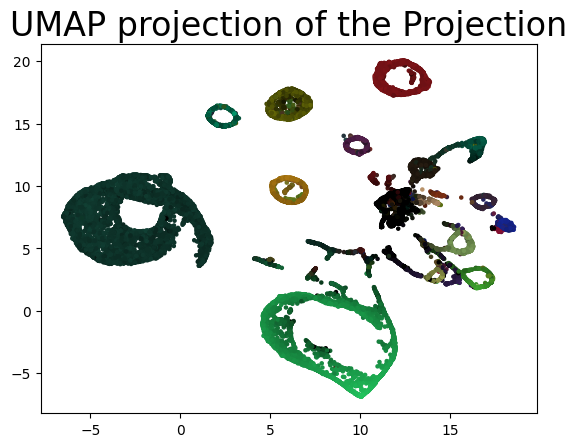

In [ ]:
import umap.umap_ as umap

# Load the color map data from the pickle file
file_path = '/content/category_colors.pkl'

with open(file_path, 'rb') as file:
    color_map_data = pickle.load(file)

# Convert your color_map_data values to a format suitable for matplotlib
label_to_color = {label: tuple(color) for label, color in color_map_data.items()}

predictions = np.load("/content/predictions_arr.npy", allow_pickle=True)
labels = np.load("/content/targets_arr.npy", allow_pickle=True)

predictions = np.concatenate([prediction for prediction in predictions], axis=0)
labels = np.concatenate([label for label in labels], axis=0)

print(f"labels shape{labels.shape}")
print(f"outputs shape{predictions.shape}")

colors_for_points = []

for label_row in labels:
    row_colors = [label_to_color[int(lbl)] for lbl in label_row]
    avg_color = np.mean(row_colors, axis=0)
    colors_for_points.append(avg_color)

colors_for_points = np.array(colors_for_points)

# UMAP projection of the HuBERT embeddings
reducer = umap.UMAP(random_state=42, n_neighbors=20, min_dist=0.1, n_components=2, metric='euclidean')
embedding_outputs = reducer.fit_transform(predictions)
plt.scatter(embedding_outputs[:, 0], embedding_outputs[:, 1], s=5, c=colors_for_points)
plt.title('UMAP projection of the Projection', fontsize=24)
plt.show()

In [ ]:
from bokeh.plotting import figure, show, output_file, save
from bokeh.models import HoverTool, ColumnDataSource
import pickle
import pandas as pd
import numpy as np
from PIL import Image
import base64
import io
from io import BytesIO


def embeddable_image(data):
    data = (data * 255).astype(np.uint8)
    # convert to uint8
    data = np.uint8(data)
    image = Image.fromarray(data)
    image = image.convert('RGB')
    # show PIL image
    im_file = BytesIO()
    img_save = image.save(im_file, format='PNG')
    im_bytes = im_file.getvalue()

    img_str = "data:image/png;base64," + base64.b64encode(im_bytes).decode()
    return img_str

# Specify an HTML file to save the Bokeh image to.
output_file(filename='umap.html')

spec_df = pd.DataFrame(embedding, columns=('x', 'y'))

# Create a ColumnDataSource from the data. This contains the UMAP embedding components and the mean colors per mini-spectrogram
source = ColumnDataSource(data=dict(x=embedding[:, 0], y=embedding[:, 1], colors=color_arr[]))

# Create a figure and add a scatter plot
p = figure(width=800, height=600, tools=('pan, box_zoom, hover, reset'))
p.scatter(x='x', y='y', size=5, color='colors', source=source)

# Set the image path for each data point
source.data['image1'] = []

for i,row in enumerate(images):
    image1 = embeddable_image(row)
    source.data['image1'].append(image1)

hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div>
        <h3>@x, @y</h3>
        <div>
            <img
                src="@image1" height="100" alt="@image1" width="100"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
    </div>
"""

p.add_tools(HoverTool(tooltips="""
"""))

save(p)



: 